# Load libraries and functions

In [1]:
rootf = './'

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
#---------------------------------
# # For clustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy as sc
# #---------------------------------
import sys
sys.path.append('./functions') 
from save_load import *
from functions_NO_MEA import*

Populating the interactive namespace from numpy and matplotlib


In [3]:
Folder_data = './data/MEA_Data/pickle/'

data = []

for i in [4,5,7,8]:
    data.append(load_obj(Folder_data + 'dict_exp0'+str(i)))

indxs = dict({4:0,5:1,7:2,8:3})
print(data[0].keys())
data[0]['ssta_c1'].shape

dict_keys(['cell_ids', 'waveform', 'chirp_psth_c1', 'chirp_psth_no', 'chirp_psth_wo', 'chirp_n_bins', 'chirp_spike_trains_c1', 'chirp_spike_trains_no', 'chirp_spike_trains_wo', 'tsta_c1', 'tsta_no', 'tsta_wo', 'ssta_c1', 'ssta_no', 'ssta_wo', 'cb_psth_c1', 'cb_psth_no', 'cb_psth_wo', 'cb_polarity_c1', 'cb_polarity_no', 'cb_polarity_wo', 'ellipse_x_c1', 'ellipse_x_no', 'ellipse_x_wo', 'ellipse_y_c1', 'ellipse_y_no', 'ellipse_y_wo', 'ellipse_size_c1', 'ellipse_size_no', 'ellipse_size_wo', 'cb_spike_trains_c1', 'cb_spike_trains_no', 'cb_spike_trains_wo'])


(107, 50, 50)

# Load spike data

In [4]:
exp=5

dataexp = data[indxs[exp]]
goodlist=dataexp['cell_ids']
goodlist,len(goodlist)

(array([  30,  205,  222,  290,  377,  457,  518,  618,  640,  796,  798,
         830,  844,  859, 1024, 1104, 1153, 1173, 1187, 1199, 1206, 1212,
        1234, 1238, 1281, 1306, 1365, 1381, 1419], dtype=int32), 29)

## create ISI

In [5]:

ISI = dict()
ALL_SPIKES = dict()
for cell_idx in np.arange(len(goodlist))[:]:

    all_spikes = np.array([])
    for sp in [dataexp['cb_spike_trains_c1'][cell_idx],dataexp['cb_spike_trains_no'][cell_idx],dataexp['cb_spike_trains_wo'][cell_idx],dataexp['chirp_spike_trains_c1'][cell_idx],dataexp['chirp_spike_trains_no'][cell_idx],dataexp['cb_spike_trains_wo'][cell_idx]]:          
        new_spikes = np.concatenate(sp,axis=0)
        all_spikes = np.concatenate([all_spikes,new_spikes],axis=0)
        
    ALL_SPIKES[cell_idx] = np.copy(all_spikes)

    interspike_intervals = compute_interspike_intervals(all_spikes,sampling_rate=1)
    
    ISI[cell_idx]=np.copy(interspike_intervals)
    
#     figure()
#     title('cell '+str(goodlist[cell_idx]))
#     hist(interspike_intervals,bins=linspace(0,0.05,100))
#     xlim([0,0.05])

# Load the good cells numbers

In [6]:
# Load cell numbers of good A or A- cells
selected_cellsA = goodlist

All_cell_groups = [selected_cellsA]
All_cell_groups

[array([  30,  205,  222,  290,  377,  457,  518,  618,  640,  796,  798,
         830,  844,  859, 1024, 1104, 1153, 1173, 1187, 1199, 1206, 1212,
        1234, 1238, 1281, 1306, 1365, 1381, 1419], dtype=int32)]

# Compute rpv

## Get info for selected group

In [7]:
# Function
import itertools
flatten = itertools.chain.from_iterable

def get_cell_rpvs(cell_lists,rpv_len):

    PLOT=False
    
    for good_clusters in cell_lists:
        cell_data ={}
        # refractory time duration lenght
        
        min_rpv=100
        max_rpv=0
        cell_count=0
        avg_rpv=0
        rpv_list=[]
        for cell_nb in np.arange(len(good_clusters[0:])):
            
            cell_data[cell_nb]={}

            spike_times = ALL_SPIKES[cell_nb]
            
            interspike_intervals = ISI[cell_nb]
            rpv = compute_refractory_period_violation(spike_times,duration=rpv_len,sampling_rate=1) # it is seconds already
            nb_rpv = compute_number_of_rpv_spikes(spike_times,duration=rpv_len,sampling_rate=1)# it is seconds already

            if min_rpv>rpv:min_rpv=rpv
            if max_rpv<rpv:max_rpv=rpv

            cell_data[cell_nb]["nb_spikes"] = len(spike_times)
            cell_data[cell_nb]["isi"] = interspike_intervals
            cell_data[cell_nb]["rpv"] = rpv
            cell_data[cell_nb]["nb_rpv_spikes"] = nb_rpv

            #------------------------------------------
            if PLOT:
                fig= figure(figsize=(3,6))
                hist(interspike_intervals,np.linspace(0,0.05,50))
                xlim([0,0.05])
                axvline(rpv_len/1000,color='k') 
                title('Cell ' + str(cell_nb) + '  Violations % '+str(np.round(rpv,2)) + '  N= '+str(nb_rpv))
            #------------------------------------------
            cell_count+=1
            avg_rpv+=rpv
            rpv_list.append(rpv)

        avg_rpv=avg_rpv/cell_count
        rpv_list=np.array(rpv_list)
        
        print('Min rpv:' ,np.round(min_rpv,2),'%')
        print('Avg rpv:' ,np.round(avg_rpv,2),'%')
        print('Median rpv:' ,np.round(np.median(rpv_list),2),'%')
        print('Max rpv:' ,np.round(max_rpv,2),'%')
        
    return cell_data

## Stats for all

In [8]:
a=get_cell_rpvs(All_cell_groups,rpv_len=2)
# a=get_cell_rpvs([selected_cellsA],rpv_len=2)


Min rpv: 0.0 %
Avg rpv: 0.05 %
Median rpv: 0.01 %
Max rpv: 0.65 %


# Select cluster or cluster groups to use and compute rpv

In [9]:
###################################
# Select group or groups to analyse
good_clusters = selected_cellsA
#good_clusters = list(flatten([selected_cellsA,selected_cellsAm]))
###################################
cell_data = get_cell_rpvs([good_clusters],rpv_len=2)  # send as list of lists
print(good_clusters)

Min rpv: 0.0 %
Avg rpv: 0.05 %
Median rpv: 0.01 %
Max rpv: 0.65 %
[  30  205  222  290  377  457  518  618  640  796  798  830  844  859
 1024 1104 1153 1173 1187 1199 1206 1212 1234 1238 1281 1306 1365 1381
 1419]


# Get cell templates

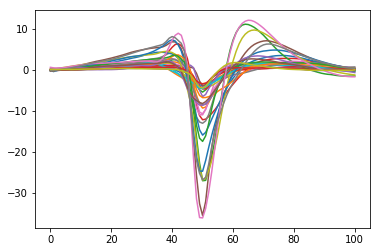

In [10]:
for cell_nb in np.arange(len(good_clusters[0:])):   
    wave = dataexp['waveform'][cell_nb]
    #----------------
    
    plot(wave)
    cell_data[cell_nb]["templates"] = wave

## Chirps

In [11]:
for cell_nb in np.arange(len((good_clusters))):

    cell_data[cell_nb]["chirp_spike_trains_c1"] = dataexp['chirp_spike_trains_c1'][cell_nb]
    cell_data[cell_nb]["chirp_spike_trains_no"] = dataexp['chirp_spike_trains_no'][cell_nb]
    cell_data[cell_nb]["chirp_spike_trains_wo"] = dataexp['chirp_spike_trains_wo'][cell_nb]
    
    cell_data[cell_nb]["psth_c1"] = dataexp['chirp_psth_c1'][cell_nb]
    cell_data[cell_nb]["psth_no"] = dataexp['chirp_psth_no'][cell_nb]
    cell_data[cell_nb]["psth_wo"] = dataexp['chirp_psth_wo'][cell_nb]

# Plot Chirp rasters

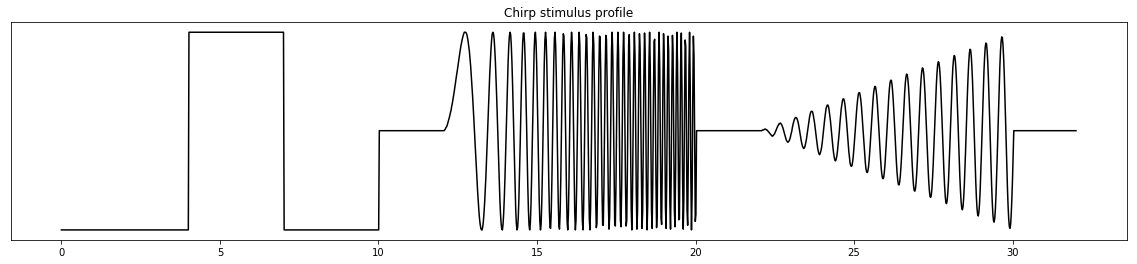

In [12]:
# Get Chirp stim profile
def get_euler():
    vec_path = rootf + '/data/'
    vec_path = vec_path + r"chirp.vec"
    euler_vec = np.genfromtxt(vec_path)

    return euler_vec

euler_vec= get_euler()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
axs.set_title("Chirp stimulus profile")
axs.plot(np.linspace(0,32,1600),euler_vec[150:1750,1], color='k')
axs.set_yticks([])
np.max(euler_vec[150:1750,1])

from matplotlib import gridspec


In [13]:
# Plot the rasters
PDF_folder = rootf + './OUTPUT_NO_MEA/chirps/'
analysis = "raster"

PLOT=False

text_title = ['first','NO','wash_out']

for cell_nb in np.arange(len(good_clusters[0:])):

    if PLOT:
        gs = gridspec.GridSpec(7,1,hspace=0.35)

        fig=figure(figsize=(18,14))
        fig.suptitle('exp'+str(exp)+'   cluster '+str(good_clusters[cell_nb]),size=20)
        for COL in [0,1,2]:
            ax= subplot(gs[(COL+1)*2-1:(COL+1)*2+1,0])

            if COL==0: 
                rdata = cell_data[cell_nb]["chirp_spike_trains_c1"]
                pdata = cell_data[cell_nb]["psth_c1"]
            if COL==1: 
                rdata = cell_data[cell_nb]["chirp_spike_trains_no"]
                pdata = cell_data[cell_nb]["psth_no"]
            if COL==2: 
                rdata = cell_data[cell_nb]["chirp_spike_trains_wo"]
                pdata = cell_data[cell_nb]["psth_wo"]
                

            ax.eventplot(rdata,color='k',lw=1,linelengths=1)

            ax.set_title('  '+text_title[COL],size=14)

            if COL==2:xlabel("Time (s)")
            if COL<2:xticks([])
            ylabel("Counts @40ms        #Trial")

            xlim([0,32])
            ylim([-20,20])
            if COL>0: ylim([-20,20])
            yticks([0,5,10,15,20])

            #---------------------------------
            norm_div=20/np.max(pdata)

            step(np.linspace(0,32,800),pdata*norm_div-20.5)
            axhline(-0.5,color='k',lw=0.75)
    #             axhline(19.5,color='k',lw=0.5)

            #---------------------------------

            if COL==0:
                ax= subplot(gs[0,0])
                ax.set_title('CHIRP '+text_title[COL])
                ax.plot(np.linspace(0,32,1600),euler_vec[150:1750,1]/265*20, color='k')
                ax.set_xlim(xlim([0,32]))
                ax.set_yticks([])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
        #----------------------------------------------------------  

        codename =  'exp'+str(exp)+'_c'+str(good_clusters[cell_nb])
        fsave = PDF_folder + '/' +codename +'_euler_raster' 

        fig.savefig(fsave+'.png',format='png',dpi=120)
        #----------------------------------------------------------
        close(fig)
    
print('Done!')

Done!


# Checkerboard

In [14]:
for cell_nb in np.arange(len((good_clusters))):

    cell_data[cell_nb]["cb_spike_trains_c1"] = dataexp['cb_spike_trains_c1'][cell_nb]
    cell_data[cell_nb]["cb_spike_trains_no"] = dataexp['cb_spike_trains_no'][cell_nb]
    cell_data[cell_nb]["cb_spike_trains_wo"] = dataexp['cb_spike_trains_wo'][cell_nb]


# STAs

In [15]:
for cell_nb in np.arange(len((good_clusters))):

    cell_data[cell_nb]["spatial_sta_c1"] = dataexp['ssta_c1'][cell_nb]
    cell_data[cell_nb]["spatial_sta_no"] = dataexp['ssta_no'][cell_nb]
    cell_data[cell_nb]["spatial_sta_wo"] = dataexp['ssta_wo'][cell_nb]
    
    cell_data[cell_nb]["temporal_sta_c1"] = dataexp['tsta_c1'][cell_nb]
    cell_data[cell_nb]["temporal_sta_no"] = dataexp['tsta_no'][cell_nb]
    cell_data[cell_nb]["temporal_sta_wo"] = dataexp['tsta_wo'][cell_nb]
    
    cell_data[cell_nb]["polarity_c1"] = dataexp['cb_polarity_c1'][cell_nb]
    cell_data[cell_nb]["polarity_no"] = dataexp['cb_polarity_no'][cell_nb]
    cell_data[cell_nb]["polarity_wo"] = dataexp['cb_polarity_wo'][cell_nb]
       
    cell_data[cell_nb]["psth_c1"] = dataexp['chirp_psth_c1'][cell_nb]
    cell_data[cell_nb]["psth_no"] = dataexp['chirp_psth_no'][cell_nb]
    cell_data[cell_nb]["psth_wo"] = dataexp['chirp_psth_wo'][cell_nb]
        
    cell_data[cell_nb]["ellipseMat_c1"]= [dataexp['ellipse_y_c1'][cell_nb],dataexp['ellipse_x_c1'][cell_nb]]
    cell_data[cell_nb]["ellipseMat_no"]= [dataexp['ellipse_y_no'][cell_nb],dataexp['ellipse_x_no'][cell_nb]]
    cell_data[cell_nb]["ellipseMat_wo"]= [dataexp['ellipse_y_wo'][cell_nb],dataexp['ellipse_x_wo'][cell_nb]]
    
    cell_data[cell_nb]["ellipseSize_c1"]= dataexp['ellipse_size_c1'][cell_nb]
    cell_data[cell_nb]["ellipseSize_no"]= dataexp['ellipse_size_no'][cell_nb]
    cell_data[cell_nb]["ellipseSize_wo"]= dataexp['ellipse_size_wo'][cell_nb]
    #--------------

In [16]:
PDF_folder = rootf + '/OUTPUT_NO_MEA/STAs/'

Temp='' # to save in 'temp' folder

PLOT=True

cmap='RdBu_r'
# interpolation='gaussian'
# interpolation='bicubic'
interpolation='none'
exp_treat=1

text_title = ['first','NO','wash_out']
i0=42      # 
iz=i0+1
# uncomment to plot all:
# i0=0
# iz=len(good_clusters)
for cell_nb in np.arange(len(good_clusters[i0:iz])):
    cell_nb=i0
    print(cell_data[cell_nb]["ellipseSize_c1"])
    print(cell_data[cell_nb]["ellipseSize_no"])
    print(cell_data[cell_nb]["ellipseSize_wo"])
    
#     print(cell_nb)
    #----------------------------------------------------------
    # PLOT
    if PLOT:
        codename =  'exp'+str(exp)+'_c'+str(good_clusters[cell_nb])
        fsave = PDF_folder + Temp +'/' +codename +'_STA'  

        gs = gridspec.GridSpec(3,2,hspace=0.35)

        fig=figure(figsize=(10,14))
        fig.suptitle('exp'+str(exp)+'   cluster '+str(good_clusters[cell_nb]),size=20)
        for COL in [0,1,2]:
            ax= subplot(gs[COL:COL+1,0:1])
#             ax.set_aspect('equal')
#             axis('equal')
            ax = plt.gca()
            ax.set_aspect('equal', adjustable='box')
            if COL==0: 
                tdata = cell_data[cell_nb]["temporal_sta_c1"]
                sdata = cell_data[cell_nb]["spatial_sta_c1"]
                Ex=cell_data[cell_nb]['ellipseMat_c1'][0]
                Ey=cell_data[cell_nb]['ellipseMat_c1'][1]
                mx=np.mean(Ex)
                my=np.mean(Ey)
            if COL==1: 
                tdata = cell_data[cell_nb]["temporal_sta_no"]
                sdata = cell_data[cell_nb]["spatial_sta_no"]
                Ex=cell_data[cell_nb]['ellipseMat_no'][0]
                Ey=cell_data[cell_nb]['ellipseMat_no'][1]
                mx=np.mean(Ex)
                my=np.mean(Ey)
            if COL==2: 
                tdata = cell_data[cell_nb]["temporal_sta_wo"]
                sdata = cell_data[cell_nb]["spatial_sta_wo"]
                Ex=cell_data[cell_nb]['ellipseMat_wo'][0]
                Ey=cell_data[cell_nb]['ellipseMat_wo'][1]
                mx=np.mean(Ex)
                my=np.mean(Ey)

            ax.step(np.linspace(-40/30,0,40),tdata,'k',lw=3)
            ax.axhline(0,color='k',lw=0.5)
            ax.set_ylim([-0.8,0.8])
            ax.set_xlabel('Time(s)')

            
            ax.set_title('  '+text_title[COL],size=14)

            ax= subplot(gs[COL:COL+1,1:2])
            sta = np.sign(sdata) * np.exp(np.log(abs(sdata)*exp_treat))
#             sta = np.sign(sdata) * np.exp(np.log(abs(sdata)*exp_treat))
            vmax=np.amax(abs(sta))*1.
            ax.imshow(sta,vmin=-vmax,vmax=vmax,cmap=cmap,interpolation=interpolation)
            ax.set_xlim(15,35)
            ax.set_ylim(35,15)

            # plot Ellipse
            
            #-----------------
#             ax= subplot(gs[line,0])
#             ax.plot(Ex,Ey,'yellow',alpha=0.75,lw=2 )#,lw=10)    #rotated ellipse
#             ax= subplot(gs[0,0])
            ax.plot(Ex,Ey,'k',lw=2 ,alpha=0.5)#,lw=10)    #rotated ellipse
#             line+=1
            chsize = 12*1
            um200ch = 200/3.5
            ax.plot()

#             ax= subplot(gs[0,0])
    
#     ax.set_title('Ellipses')
#     ax.set_xlim([15,35])
#     ax.set_ylim([35,15])
#     ax.set_aspect('equal')
#     ax.set_xticks([])
#     ax.set_yticks([])

        fig.savefig(fsave+'.png',format='png',dpi=90)
#         close(fig)
    #--------------
print('Done!')

Done!


# Select the best cells
Those that have a nice response to the chirp and a weel defined STA

In [17]:
bad_STAs = []
bad_chirps = []

selected_cells = []
for c in good_clusters:
    if not c in bad_STAs and not c in bad_chirps:
        selected_cells+= [c]

print("Selected {} cells.".format(len(selected_cells)))
len(good_clusters),len(selected_cells)

Selected 29 cells.


(29, 29)

# Cell typing

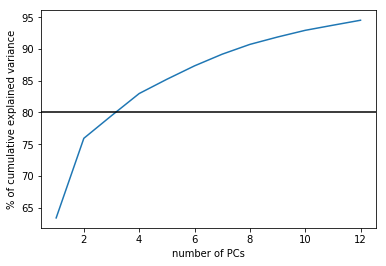

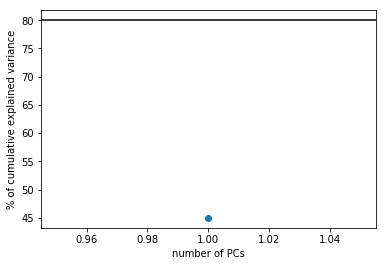

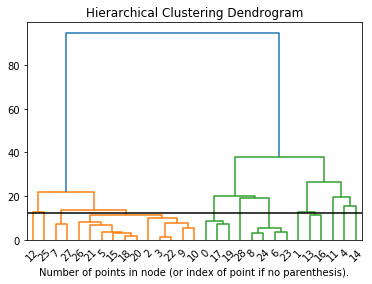

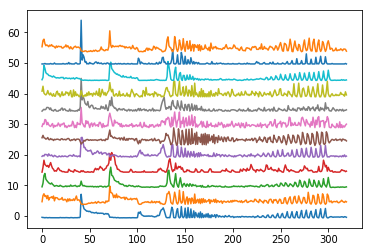

Number of clusters:  12
cluster size : 11


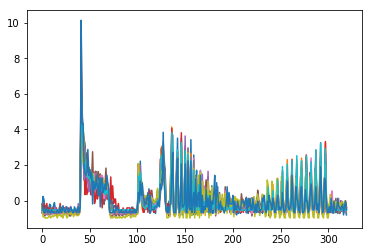

cluster size : 2


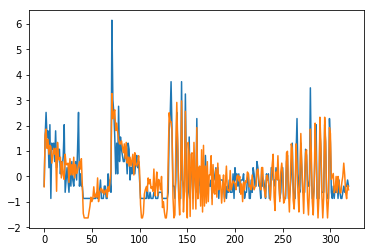

cluster size : 3


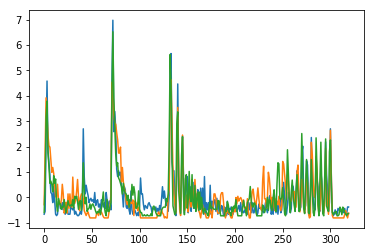

cluster size : 1


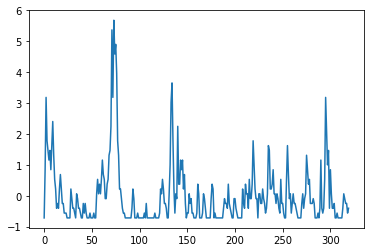

cluster size : 2


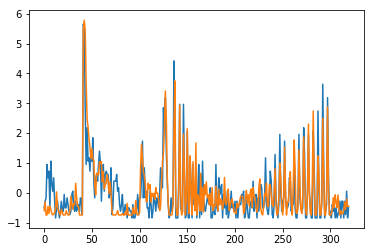

cluster size : 1


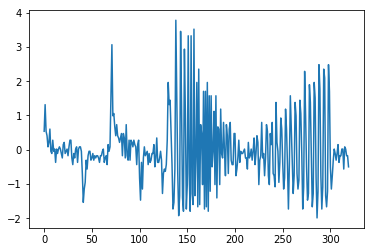

cluster size : 1


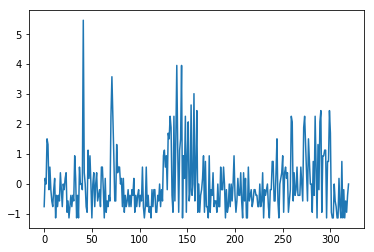

cluster size : 1


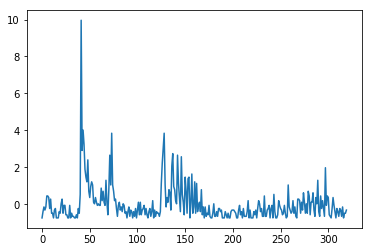

cluster size : 1


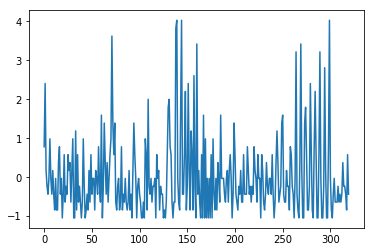

cluster size : 4


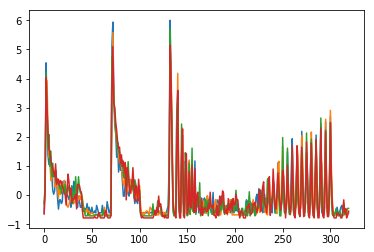

cluster size : 1


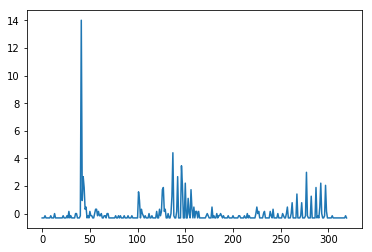

cluster size : 1


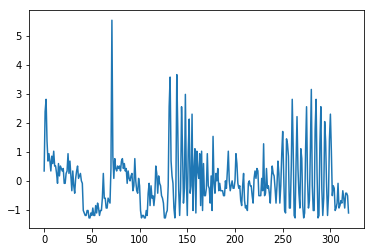

In [18]:
# from sklearn.decomposition import SparsePCA
sparse=False
# change dist_thres to adapt the cut of the dendrogram and select the number of clusters
#####################################################################
dth = [0,0,0,0,13,12,0,12,11.5]
dist_thres = dth[exp]#        # adapt threshold depending on experiment number: exp4=13 - exp5=12 exp7=12 - exp8=11.5
#####################################################################

n_cells = len(selected_cells)
#-----------------------------------
#-----------------------------------
# Get chirp PCA
n_rep = 20 # nb of repeats
nt = 32 # total length
dt = 0.1 # bin size

time_bins = np.arange(0,nt+dt,dt)

spikes = np.zeros((n_cells, int(nt/dt), n_rep))
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    spike_cell = dataexp['chirp_spike_trains_c1'][cell_index]
    for rep in range(n_rep):
        temp=np.histogram(spike_cell[rep], bins=time_bins)
        spikes[cell_index,:,rep] = temp[0]

#-------------------------
# Pre process the PSTH
psth = np.mean(spikes, 2)
psth_z = scipy.stats.zscore(psth, 1)

# Select number of PCs to keep (here 13 explain ~80% of the variance)
#####################################################################
n_components_psth = 12    #change depending on experiment: exp4=12 - exp5=12 exp7=12 - exp8=11
if exp==8:
    n_components_psth = 11
#####################################################################
if sparse:
   pca_transformer = SparsePCA(n_components_psth, random_state=0).fit(psth_z)
else:
   pca_transformer = PCA(n_components_psth).fit(psth_z)
psth_pca = pca_transformer.transform(psth_z)
# -----------------------------------
# -----------------------------------
# Get checkerboard STA PCA
STA_time_course = np.zeros((n_cells,40))  #21 data points for these STAs
for cell_index in range(len(selected_cells)):
    TempSTA_cell = cell_data[cell_index]["temporal_sta_c1"]
    STA_time_course[cell_index] = TempSTA_cell
#---------------------------
# Pre process the STA
sta_tc = sc.stats.zscore(STA_time_course[:,:], 1)
#####################################################################
n_components_sta_tc = 2    #change depending on experiment: exp4=2 - exp5=1 exp7=2 - exp8=2
if exp==5:
    n_components_sta_tc = 1
#####################################################################
if n_components_sta_tc>0:
    pca_transformer2 = PCA(n_components_sta_tc).fit(sta_tc)
    sta_tc_pca = pca_transformer2.transform(sta_tc)
#-----------------------------------
#-----------------------------------
if not sparse:
    plt.plot(np.arange(n_components_psth)+1, np.cumsum(pca_transformer.explained_variance_ratio_)*100)
    plt.axhline(y=80, color='k')
    plt.xlabel('number of PCs')
    plt.ylabel('% of cumulative explained variance')
    plt.show()

    if n_components_sta_tc>0:
        plt.plot(np.arange(n_components_sta_tc)+1, np.cumsum(pca_transformer2.explained_variance_ratio_)*100,'o-')
        plt.axhline(y=80, color='k')
        plt.xlabel('number of PCs')
        plt.ylabel('% of cumulative explained variance')
        plt.show()
#-----------------------------------
#-----------------------------------
cluster_dataset = np.zeros((n_cells, n_components_psth+n_components_sta_tc+1))
cluster_dataset[:,:n_components_psth] = psth_pca
if n_components_sta_tc>0:
    cluster_dataset[:,n_components_psth:n_components_psth+n_components_sta_tc] = sta_tc_pca

ell_size=np.zeros(len(selected_cells))
for cell_index in range(len(selected_cells)):
#     width,height = cell_data[cell_index]["ellipseSigmaXY"]
    ell_size[cell_index] = cell_data[cell_index]["ellipseSize_c1"]   #np.abs(np.pi*width*height)
    
ell_size_temp = -np.ones(n_cells)
temp = ell_size[:]-ell_size[:].min()
ell_size_temp[:] = temp/temp.max()
cluster_dataset[:,-1] = ell_size_temp
#-----------------------------------
#-----------------------------------

# perform agglomerative clustering
model = AgglomerativeClustering(distance_threshold=dist_thres, n_clusters=None)
#model = model.fit(psth_pca)
model = model.fit(cluster_dataset)

# plot the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=0)
plt.axhline(dist_thres, color='k')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# plot the cluster centroids
n_clusts = len(np.unique(model.labels_))
plt.figure()
for iclust in range(n_clusts):
    idx_cluster = np.where(model.labels_==iclust)[0]
    plt.plot(np.mean(psth_z[idx_cluster,:], 0) + iclust * 5)
plt.show() 
    
print('Number of clusters: ',len(np.unique(model.labels_)))

# plot the psths of all cells in one cluster
for icluster in range(len(np.unique(model.labels_))):
    # icluster = 0
    idx_cluster = np.where(model.labels_==icluster)[0]
    print(f'cluster size : {len(idx_cluster)}')
    plt.figure()
    plt.plot(psth_z[idx_cluster,:].transpose())
    plt.show()

# Create a summary figure for each cluster type

In [19]:
from matplotlib import gridspec

# for icluster in range(len(np.unique(model.labels_)))[0:]:

for icluster in [20]: # select clusters if not use [:]

    idx_cluster = np.where(model.labels_==icluster)[0]
    print(len(idx_cluster))

    gs = gridspec.GridSpec(len(idx_cluster)+2,6)
    
    #subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
    if len(idx_cluster)<7:
        yspan = 2
    else:
        yspan=-2
    fig=figure(figsize=(14,(len(idx_cluster)+yspan)*1.75))
    #axs = fig.add_subplot(nrows=len(idx_cluster)+1, ncols=3, figsize=(16,16))
    plt.suptitle("Cell group {}.\n {} cells.".format(icluster, len(idx_cluster)))

    #-------------------------------
    # Loop cells in cluster
    line = 2
    STAs=np.zeros(40)
    STAcount=0
    waves=np.zeros(101)
    wavecount=0
    for cell_nb in sorted(idx_cluster):
        
        #-----------------
        # Plot temp STA
        ax= subplot(gs[line,1])
        
        ax.set_ylim([-0.75,0.75])
        ax.axis("off")
#         ax.set_aspect(0.075)
        ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta_c1"],'k',lw=3)
        polarity = cell_data[cell_nb]["polarity_c1"]
        ax.set_title('Cluster ' + str(selected_cells[cell_nb]) + '  Polarity '+str(int(polarity)))
        ax.axhline(0,color='k',lw=0.5)
        
        STAs+=cell_data[cell_nb]["temporal_sta_c1"]
        STAcount+=1
        
        #-----------------
        # Plot temp STA avg
        ax= subplot(gs[0,1])
        
        ax.set_title('Temp STA')
        ax.set_ylim([-0.75,0.75])
        ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta_c1"],lw=0.5)
        ax.axhline(0,color='k',lw=0.5)

        ax.set_xlabel('Time(s)')
        #-----------------
        # plot Spatial STA
        ax= subplot(gs[line,0])
                
        ax.imshow(cell_data[cell_nb]["spatial_sta_c1"], cmap='gray',interpolation='gaussian')
        ax.set_xlim(15,35)
        ax.set_ylim(35,15)
        ax.set_aspect('equal')
        #ax.set_title('Cluster' + str(cell_nb))
        ax.set_xticks([])
        ax.set_yticks([])
       
        #----------------
        #plot waveform
        ax= subplot(gs[line,2])
        
        wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
        ax.plot(wave,'r')
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        waves+=wave
        wavecount+=1
        
        ax= subplot(gs[0,2])
        ax.plot(wave,lw=0.5)
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        #-----------------
        # plot Euler
        ax= subplot(gs[line,3:])
        
        cell_index=cell_nb
        ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth_c1"])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        plt.locator_params(axis="y", nbins=3)
        
#         ax= subplot(gs[0,3:])
#         ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
        #-----------------
        # plot Ellipse
        Ex=cell_data[cell_nb]['ellipseMat_c1'][0]
        Ey=cell_data[cell_nb]['ellipseMat_c1'][1]
        mx=np.mean(Ex)
        my=np.mean(Ey)

        #-----------------
        ax= subplot(gs[line,0])
        ax.plot(Ex,Ey,'yellow',alpha=0.5 )#,lw=10)    #rotated ellipse
        ax= subplot(gs[0,0])
        ax.plot(Ex,Ey,'k',lw=0.5 )#,lw=10)    #rotated ellipse
        line+=1  
        
    #-----------------
    # avg STA
    STAs=STAs/STAcount
    ax= subplot(gs[0,1])
    ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
    ax.set_ylim([-0.75,0.75])
#     ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # avg wave
    waves=waves/wavecount
    ax= subplot(gs[0,2])
    ax.set_title('Waveform')
    
    ax.plot(waves,'r',lw=2)
    ax.set_ylim([-1.25,1.25])
    #ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # size ellipses
    ax= subplot(gs[0,0])
    
    ax.set_title('Ellipses')
    ax.set_xlim([15,35])
    ax.set_ylim([35,15])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    #-----------------
    # mean psth
    ax= subplot(gs[0,3:])
    ax.set_title('Euler psth')
    
    ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'b')
    ax.axis("off")

    #-----------------
    # plot euler stim
    euler_vec= get_euler()
    ax= subplot(gs[1,3:])
    
    ax.plot(np.linspace(0,32,1600),euler_vec[150:1750,1], color='k')
    ax.set_yticks([])
    ax.set_ylim([-100,350])
    ax.set_xlabel('Time(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax= subplot(gs[1,2])
    ax.text(0.5,0.5 ,"Chirp stimulus profile")
    ax.axis("off")
    
    PDF_folder = rootf + '/OUTPUT_NO_MEA/Cell_type/'
    fsave = PDF_folder +'exp'+str(exp)+'_clustype' +str(icluster) 
    
    fig.savefig(fsave+'.png',format='png',dpi=250)
    close(fig)  
    
print('Done!')

0


/Users/matias/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide
/Users/matias/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in true_divide
/Users/matias/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/matias/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done!


# Create an ID card for each cell

In [20]:
# More complicated ID card
ttext = ['native','  NO','  wo']
PLOT = False

if PLOT:
    for idx_cell in (range(len(selected_cells[0:]))):
    # for index in range(1):
        cell_nb = idx_cell

        # Create the figure
        fig = plt.figure(figsize=(20, 12))

        # the size of the marginal axes and the main axes in both directions.
        gs = gridspec.GridSpec(8, 8,
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.3, hspace=0.8)   
        gridspec.GridSpec
        try:
            cluster = model.labels_[idx_cell]#[0]
        except:
            cluster=''

        cell_data[cell_nb]["clus_ID"]=cluster

        plt.suptitle("exp{} _c{}  - Cluster_group_{} ".format(exp,selected_cells[cell_nb],cluster), fontsize=20)
        #--------------------------------------------------
        # Plot the ISI
        ax = fig.add_subplot(gs[0:1, 3:4])
        ax.hist(cell_data[cell_nb]['isi'], bins = 100, range=(0,0.05))
        rpv = cell_data[cell_nb]['rpv']
        nb_rpv= cell_data[cell_nb]['nb_rpv_spikes']
        ax.set_title("Interspike Interval histogram\n RPV = {}%. {}/{} spikes.".format(round(rpv,4), nb_rpv, cell_data[cell_nb]["nb_spikes"]))
    #     ax.set_xlabel("Interspike time (s)")
    #     ax.set_ylabel("Number of spikes")
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axvline(0,color='k',lw=0.5)

        #--------------------------------------------------
        # Plot the cell's template
        ax = fig.add_subplot(gs[0:1, 4:5])
        wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
        ax.plot(np.linspace(-2.5,2.5,101),wave,color='r',lw=2)
        ax.set_title("Cell template")
    #     ax.set_xlabel("Time (ms)")
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axhline(0,color='k',lw=0.5)
        ax.set_ylim([-1.25,1.25])
        ax.set_yticks([])

        #--------------------------------------------------
        # Plot spatial STA
        for i in [0,1,2]:
            if i==0:spatial=cell_data[cell_nb]['spatial_sta_c1']
            if i==1:spatial=cell_data[cell_nb]['spatial_sta_no']
            if i==2:spatial=cell_data[cell_nb]['spatial_sta_wo']

            ax = fig.add_subplot(gs[2+i*2:4+i*2, 4:5])
            if i==0:ax.text(14,11.35,"Spatial receptive field",size=12)
            spatial = spatial**2*sign(spatial)
            cmap='RdBu_r'
            im = ax.imshow(spatial, cmap=cmap,interpolation='gaussian')
            # plt.colorbar(im, ax=axs[1,2])
            abs_max = 0.5*max(np.max(spatial), abs(np.min(spatial)))
            im.set_clim(-abs_max,abs_max)

            u250 = 1/42*50*2  *2.5
            ax.set_xticks(np.arange(10)*u250)
            ax.set_xticklabels(labels = np.arange(10)*250-750)
            ax.set_yticks(np.arange(10)*u250)
            ax.set_yticklabels(labels = np.arange(10)*250-750)

            ax.set_xlim([15,35])
            ax.set_ylim([35,15])
            ax.set_xlabel(r'$\mu$ m')
            ax.set_ylabel('$\mu$ m            ')

        #--------------------------------------------------
        # Plot checkerboard repeated sequence raster
        for i in [0,1,2]:
            if i==0:check=cell_data[cell_nb]['cb_spike_trains_c1']
            if i==1:check=cell_data[cell_nb]['cb_spike_trains_no']
            if i==2:check=cell_data[cell_nb]['cb_spike_trains_wo']    

            ax = fig.add_subplot(gs[2+i*2:3+i*2, 5:8])
            ax.eventplot(check, color='k', alpha=1,linelengths=1)
            if i==0:ax.set_title("Repeated white noise sequences")
    #         ax.set_xlabel("Time (s)")
            ax.set_xlim([0,20])
            ax.set_ylim([0,None])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        #--------------------------------------------------
        # Plot checkerboard repeated sequence psth (superimposed)

            ax = fig.add_subplot(gs[3+i*2:4+i*2, 5:8])

            nb_rep=len(check)
            psthch = np.histogram(np.concatenate(check).tolist(), bins=linspace(0,20,601))[0]/nb_rep*1000/30
            ax.plot(np.linspace(0,20,600), psthch)
            if i==2: ax.set_xlabel("Time (s)")
            ax.set_xlim([0,20])
        #     ax.set_ylabel("Firing rate (spikes/s)")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            cell_data[cell_nb]["check_psth"] = psthch

        #--------------------------------------------------
        # Plot temporal STA
        for i in [0,1,2]:
            if i==0:temporal=cell_data[cell_nb]['temporal_sta_c1']
            if i==1:temporal=cell_data[cell_nb]['temporal_sta_no']
            if i==2:temporal=cell_data[cell_nb]['temporal_sta_wo']

            ax = fig.add_subplot(gs[2+i*2:4+i*2, 3:4])
            if i==0:ax.set_title("Temporal receptive field")
            ax.step(np.linspace(-40/30,0,40), temporal,color='k',lw=3)
            ax.set_xlabel("Time (s)")
            ax.axhline(0,color='k',lw=0.5)

            ax.set_yticks([])
            ax.axis('off')

        #--------------------------------------------------
        # Plot chirp psth
        for i in [0,1,2]:
            if i==0:psth=cell_data[cell_nb]['psth_c1']
            if i==1:psth=cell_data[cell_nb]['psth_no']
            if i==2:psth=cell_data[cell_nb]['psth_wo']

            ax = fig.add_subplot(gs[3+i*2:4+i*2, 0:3])

            ax.plot(np.linspace(0,32,800), psth,lw=1)
            # ax.set_ylim(-5,2*np.max(data_20210316[cell_nb]["euler_full_field"]["psth"]))
            if i==2:ax.set_xlabel("Time (s)")
            ax.set_ylabel("Firing rate (spikes/s)")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xlim(0, 32)

        #--------------------------------------------------
         # Plot euler raster
            ax = fig.add_subplot(gs[2+i*2:3+i*2, 0:3])
            if i==0:chirp=cell_data[cell_nb]['chirp_spike_trains_c1']
            if i==1:chirp=cell_data[cell_nb]['chirp_spike_trains_no']
            if i==2:chirp=cell_data[cell_nb]['chirp_spike_trains_wo']

            ax.eventplot(chirp, color='k', alpha=1,linelengths=1,lw=1)
            ax.set_xlim(0, 32)
            ax.set_ylim(0, 20)
            # ax.set_yticks([])
            ax.set_ylabel("#Trial")
            if i==0:ax.set_title("Response to the chirp stimulus")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)


            ax.text(-8,-5,ttext[i],size=20)


        #--------------------------------------------------
        # Plot euler stimulus profile (superimposed)
        ax = fig.add_subplot(gs[1:2, 0:3])
        ax.plot(np.linspace(0,32,1600),euler_vec[150:1750,1], color='k',lw=0.75)
        # ax.set_ylim(-800,300)
        ax.set_yticks([])
        ax.set_title("Chirp stimulus profile")
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(0, 32)


        PDF_folder = rootf + '/OUTPUT_NO_MEA/Cell_ID/'
        fsave = PDF_folder +'exp'+str(exp)+'_c' +str(selected_cells[cell_nb]) + '_group' + str(cluster) + '_ID' 

        fig.savefig(fsave+'.png',format='png',dpi=110)
        close(fig)  
    print('Done!')

# Ellipse resizing Group 32

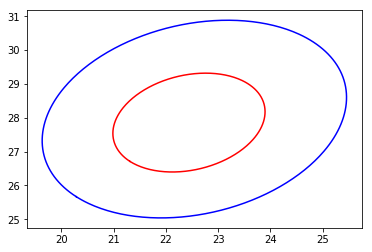

In [21]:
for cell_nb in np.arange(len((good_clusters))):

    cell_data[cell_nb]["ellipseMat_c1"]= [dataexp['ellipse_y_c1'][cell_nb],dataexp['ellipse_x_c1'][cell_nb]]

for cell_nb in np.arange(len(selected_cells)):
    Ex=cell_data[cell_nb]['ellipseMat_c1'][0]
    Ey=cell_data[cell_nb]['ellipseMat_c1'][1]
    
    mx=np.mean(Ex)
    my=np.mean(Ey)
    
    if exp==5:
        if selected_cells[cell_nb]==859:  # correct size and position of gaussian fit
            #-------------------
            px=0.5
            py=0.5
            sx=-0.1
            sy=-0.1
        if selected_cells[cell_nb] in [859]:
            plot(Ex,Ey,'b')
            Ex=px*Ex+mx*(1-px)+sx
            Ey=py*Ey+my*(1-py)+sy
            cell_data[cell_nb]["ellipseMat_c1"]= [Ex,Ey]
            plot(Ex,Ey,'r')

            #-----------------
    if exp==7:
        if selected_cells[cell_nb]==190:   # correct size and position of gaussian fit
            px=0.65
            py=0.75
            sx=-0.2
            sy=0.2
        if selected_cells[cell_nb] in [190]:
            plot(Ex,Ey,'b')
            Ex=px*Ex+mx*(1-px)+sx
            Ey=py*Ey+my*(1-py)+sy
            cell_data[cell_nb]["ellipseMat_c1"]= [Ex,Ey]
            plot(Ex,Ey,'r')
        #-----------------    

        
            

# SAVE DATA

In [22]:
Fsave = rootf + '/data/MEA_Data/pckls_ID/'
fsave = Fsave + 'exp'+str(exp) + '_celldataID'
save_obj(cell_data,fsave)

fsave = Fsave + 'exp'+str(exp) + '_clustermodel'
save_obj([model,psth_z],fsave)

fsave = Fsave + 'exp'+str(exp) + '_selected_cells'
save_obj(selected_cells,fsave)